In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import activations, datasets, layers, models, regularizers
from IPython.display import clear_output
from keras.layers.advanced_activations import LeakyReLU
import datetime
from tensorflow.keras.layers import Layer
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout, Input, Conv2D, Flatten, BatchNormalization, Reshape, Conv2DTranspose
from keras import backend
from keras.constraints import Constraint
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.manifold import TSNE
import time

# Dataset
#### Here we simply download and convert the dataset

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)

test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)

train_dataset_images = train_dataset_images.map(lambda img: img/255)
train_dataset_images = train_dataset_images.map(lambda img: tf.reshape(img, (28,28,1)))
test_dataset_images = test_dataset_images.map(lambda img: img/255)
test_dataset_images = test_dataset_images.map(lambda img: tf.reshape(img, (28,28,1)))

train_dataset = train_dataset_images.batch(128)
train_dataset.shuffle(128)

test_dataset = test_dataset_images.batch(128)
test_dataset.shuffle(128)

<ShuffleDataset shapes: (None, 28, 28, 1), types: tf.float32>

# Discriminator
####We create a simple discriminator class where we use dense-, flatten-, LeakyReLU- und dropout-layer which tries to identifiy pictures which were artificially generated. We use LeakyReLu-Layer because they allow a small, non-zero gradient when the unit is not active.

In [ ]:
class discriminator(tf.keras.layers.Layer):
  def __init__(self, in_shape=(28,28,1)):
    super(discriminator, self).__init__()

    self.dense1 = Dense(1, input_shape=in_shape)
    self.flatten0 = Flatten()
 
    self.dense2 = Dense(256, activation = None)
    self.relu2 = LeakyReLU(alpha=0.2)
    self.dropout2 = Dropout(0.4)
 
    self.dense3 = Dense(128, activation = None)
    self.relu3 = LeakyReLU(alpha=0.2)
    self.dropout3 = Dropout(0.4)

    self.dense4 = Dense(64, activation = None)
    self.relu4 = LeakyReLU(alpha=0.2)
    self.dropout4 = Dropout(0.4)
    self.dense = Dense(1, activation='sigmoid')
    
  def call(self, x, training_flag):
    x = self.dense1(x)
    x = self.flatten0(x)
    x = self.dense2(x)
    x = self.relu2(x)
    x = self.dropout2(x, training = training_flag)
    x = self.dense3(x)
    x = self.relu3(x)
    x = self.dropout3(x, training = training_flag)
    x = self.dense4(x)
    x = self.relu4(x)
    x = self.dropout4(x, training = training_flag)
    x = self.dense(x)
    return x

#Generator
#### The generator on the other hand tries to outplay the discriminator and therefor has to constantly improve its ability to generate pictures to keep up with the improving discriminator class. 
####To achieve this we use a dense-layer in the beginning which has the exact number of nodes so that it can be reshaped appropiatly into a final image by the reshape and Conv2DTranspose-Layers.

In [ ]:
class generator(tf.keras.layers.Layer):
  def __init__(self, n_nodes=7*7*256, latent_dim=(100,)):
    super(generator, self).__init__()
    self.dense0 = Dense(n_nodes, input_shape=latent_dim, activation = None)
    self.normalize0 = BatchNormalization()
    self.relu0 = LeakyReLU()

    self.shape1 = Reshape((7, 7, 256))
    self.transpose1 = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation = None)
    self.normalize1 = BatchNormalization()
    self.relu1 = LeakyReLU()

    self.transpose2 = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation = None)
    self.normalize2 = BatchNormalization()
    self.relu2 = LeakyReLU()

    self.transpose3 = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')

  
  def call(self, x, training_flag):
    x = self.dense0(x)
    x = self.normalize0(x, training = training_flag)
    x = self.relu0(x)
    x = self.shape1(x)
    x = self.transpose1(x)
    x = self.normalize1(x, training = training_flag)
    x = self.relu1(x)
    x = self.transpose2(x)
    x = self.normalize2(x, training = training_flag)
    x = self.relu2(x)
    x = self.transpose3(x)
    return x

#Training
#### During each train_step we first create the LossFunction (BinaryCrossentropy) and the adam-optimizers. Then we create a random noise "picture" which is then transformed by the generator into some artificialy generated pictures.
####After that we train the discriminator for 3 epochs on the original and the generated pictures.
####At last we train the generator using the generator_loss (gen_loss) which is based on  the output created by the discriminator for the fake images

In [ ]:
def train_step(discriminator, generator, images):
  cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  generator_optimizer = tf.keras.optimizers.Adam(1e-4)
  discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


  noise = tf.random.normal([128, 100])
  
  images_to_visualize = []
  with tf.GradientTape() as gen_tape:
    generated_images = generator.call(noise, True)
    for i in range(10):
      images_to_visualize.append(generated_images[i*10])

    for _ in range(3):
      with tf.GradientTape() as disc_tape:
        real_output = discriminator.call(images, True)
        fake_output = discriminator.call(generated_images, True)
        disc_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) + cross_entropy(tf.ones_like(real_output), real_output)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    real_output = discriminator.call(images, True)
    fake_output = discriminator.call(generated_images, True)

    gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    disc_loss = -1*(cross_entropy(tf.ones_like(fake_output), fake_output) + cross_entropy(tf.zeros_like(real_output), real_output))

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss, disc_loss, images_to_visualize

####This function just calculates the remaining time until training is finished and is therefor not really relevant

In [ ]:
def calculateTime(epochs, time_passed, number_of_epochs):
    epochs = epochs + 1
    time_per_epoch = time_passed / epochs
    number = number_of_epochs - epochs
    time_sec = number * time_per_epoch
    time_remain = str(datetime.timedelta(seconds=time_sec))
    return time_remain

####Visualize(gen_losses, disc_losses) displays the loss graph

In [ ]:
def visualize(gen_losses, disc_losses):
  plt.figure()
  line1, = plt.plot(gen_losses)
  line2, = plt.plot(disc_losses)
  plt.xlabel("Training steps")
  plt.ylabel("Loss")
  plt.legend((line1,line2),("Generator","Discriminator/Critic"))
  plt.show()
  if len(gen_losses) >= 2:
    print("Change of gen loss to previous epoch: ", gen_losses[-1] - gen_losses[-2])
  print("Current Discriminator/Critic loss: ", disc_losses[-1])
  if len(disc_losses) >= 2:
    print("Change of Discriminator/Test loss to previous epoch: ", disc_losses[-1] - disc_losses[-2])

####Visualize(images) displays 10 images created by the generator during training

In [ ]:
def visualize_images(images):
  fig, ax = plt.subplots(2,5)
  for i in range(5):
    ax[0][i].imshow(tf.reshape(images[i], (28,28)), cmap='gray')
    ax[0][i].get_xaxis().set_visible(False)
    ax[0][i].get_yaxis().set_visible(False)
    ax[1][i].imshow(tf.reshape(images[i+1], (28,28)), cmap='gray')
    ax[1][i].get_xaxis().set_visible(False)
    ax[1][i].get_yaxis().set_visible(False)
  plt.show()

####After creating the generator and discriminator, we define the running_average_factor, number of epochs and the variables used to store all of the generator and discriminator losses
#### For each epoch we go through the training dataset and train the discriminator and generator using the train_step()-function. After that we just do some more or less fancy calculations to display the graphs in a meaningful way afterwards

Epoch: __ 19


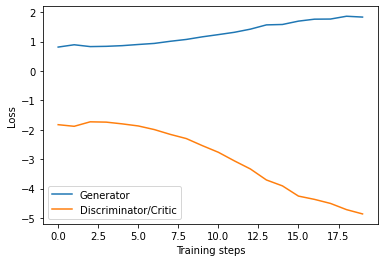

Change of gen loss to previous epoch:  tf.Tensor(-0.028543591, shape=(), dtype=float32)
Current Discriminator/Critic loss:  tf.Tensor(-4.862435, shape=(), dtype=float32)
Change of Discriminator/Test loss to previous epoch:  tf.Tensor(-0.14574194, shape=(), dtype=float32)


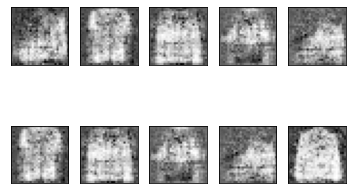

Time remain:  0:00:00


In [ ]:
GAN_generator= generator()
discriminator= discriminator()

running_average_factor = 0.95

epochs = 20
gen_losses = []
disc_losses = []

start_time = time.time()
for epoch in range(epochs):
  try:
    running_average_gen = 0
    running_average_disc = 0
    for input in train_dataset:
      gen_loss, disc_loss, generated_images = train_step(discriminator, GAN_generator, input)
      running_average_gen = running_average_factor * running_average_gen  + (1 - running_average_factor) * gen_loss
      running_average_disc = running_average_factor * running_average_disc  + (1 - running_average_factor) * disc_loss
    gen_losses.append(running_average_gen)
    disc_losses.append(running_average_disc)
    clear_output(wait = True)
    print('Epoch: __ ' + str(epoch))
    visualize(gen_losses, disc_losses)
    visualize_images(generated_images)
    print("Time remain: ", calculateTime(epoch, time.time()-start_time, epochs))
  except KeyboardInterrupt as e:
    break

#### As we can see the generator now doesn't produce very clear images. However, it needs to be mentioned that in most epochs the images looked a lot better than the results here. The quality varied significantly over different epochs which is a due to the instability of GANs.

# Wasserstein Loss

#### We define two new loss functions for the WGAN.
#### One for the critic where we use the Wasserstein difference between the real and fake outputs. We take the negative of this metric because we want it to be high and in our train_step function the loss is minimized.
#### The second loss function is for the WGAN's generator and just returns the negative of the average of critic's output for fake images. Again we take the negative here because we want the average to be high while our train_step function is minimizing losses.

In [ ]:
def wasserstein_critic_loss(real_output, fake_output):
    loss = -(tf.math.reduce_mean(real_output) - tf.math.reduce_mean(fake_output))
    return loss

In [ ]:
def wasserstein_gen_loss(fake_output):
  return -tf.math.reduce_mean(fake_output)

# WGAN Model

#### Before we implement the classes for the WGAN model, we implement a class for clipping the weights in the critic. This class is based on Keras' constraint class and is expending it by a call function to clip the weights by the specified values. 

In [ ]:
# define class for kernel and bias constraints
class ClipConstraint(Constraint):
  def __init__(self, clip_border):
    self.clip_border = clip_border
  
  def __call__(self, weights):
    return backend.clip(weights, -self.clip_border, self.clip_border)

  def get_congig(self):
    return {'clip_border': self.clip_border}

constraint = ClipConstraint(0.01)

#### We implement the critic class the same way we did for the discriminator class in the GAN. The only things that needed to be changed are:
#### - applying weight clipping in the layers by using kernel_constraint and bias_constraint
#### - use the linear activation function in the output layer

In [ ]:
# define the standalone critic model for the WGAN
class Critic(tf.keras.layers.Layer):
  def __init__(self, in_shape=(28,28,1)):
    super(Critic, self).__init__()

    self.dense1 = Dense(1, input_shape=in_shape, activation = None, kernel_constraint = constraint, bias_constraint = constraint)
    self.flatten0 = Flatten()

    self.dense2 = Dense(256, activation = None, kernel_constraint = constraint, bias_constraint = constraint)
    self.relu2 = LeakyReLU(alpha=0.2)
    self.dropout2 = Dropout(0.4)

    self.dense3 = Dense(128, activation = None, kernel_constraint = constraint, bias_constraint = constraint)
    self.relu3 = LeakyReLU(alpha=0.2)
    self.dropout3 = Dropout(0.4)

    self.dense4 = Dense(64,activation = None, kernel_constraint = constraint, bias_constraint = constraint)
    self.relu4 = LeakyReLU(alpha=0.2)
    self.dropout4 = Dropout(0.4)
    self.dense = Dense(1, activation='linear')
    
  def call(self, x, training_flag):
    x = self.dense1(x)
    x = self.flatten0(x)
    x = self.dense2(x)
    x = self.relu2(x)
    x = self.dropout2(x, training = training_flag)
    x = self.dense3(x)
    x = self.relu3(x)
    x = self.dropout3(x, training = training_flag)
    x = self.dense4(x)
    x = self.relu4(x)
    x = self.dropout4(x, training = training_flag)
    x = self.dense(x)
    return x

#### The generator for the WGAN we implemented in the same way we did for the GAN.

In [ ]:
# define the standalone generator model for the WGAN
class WGAN_Generator(tf.keras.layers.Layer):
  def __init__(self, n_nodes=7*7*256, latent_dim=(100,)):
    super(WGAN_Generator, self).__init__()
    self.dense0 = Dense(n_nodes, input_shape=latent_dim, activation = None)
    self.normalize0 = BatchNormalization()
    self.relu0 = LeakyReLU()

    self.shape1 = Reshape((7, 7, 256))
    self.transpose1 = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation = None)
    self.normalize1 = BatchNormalization()
    self.relu1 = LeakyReLU()

    self.transpose2 = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False,activation = None)
    self.normalize2 = BatchNormalization()
    self.relu2 = LeakyReLU()

    self.transpose3 = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')

  
  def call(self, x, training_flag):
    x = self.dense0(x)
    x = self.normalize0(x, training = training_flag)
    x = self.relu0(x)
    x = self.shape1(x)
    x = self.transpose1(x)
    x = self.normalize1(x, training = training_flag)
    x = self.relu1(x)
    x = self.transpose2(x)
    x = self.normalize2(x, training = training_flag)
    x = self.relu2(x)
    x = self.transpose3(x)
    return x

# Training the WGAN

#### First we initialize the optimizers. Here we use RMSprop with a learning rate of 0.00005 for both the generator and the critic.


In [ ]:
WGAN_generator_optimizer = tf.keras.optimizers.RMSprop(0.00005)
critic_optimizer = tf.keras.optimizers.RMSprop(0.00005)

#### Then we implement the training step for the WGAN. It is mostly like the one for the GAN with the exception that we now train the critic 5 times before training the generator and that we use the respective Wasserstein loss from above as loss functions for generator and critic.

In [ ]:
def wasserstein_train_step(critic, generator, images):
    noise = tf.random.normal([128, 100])
    images_to_visualize = []
    with tf.GradientTape() as gen_tape, tf.GradientTape() as critic_tape:
      generated_images = generator.call(noise, True)
      for i in range(10):
        images_to_visualize.append(generated_images[i*10])

      for _ in range(5):
        with tf.GradientTape() as critic_tape:
          real_output = critic.call(images, True)
          fake_output = critic.call(generated_images, True)
          critic_loss = wasserstein_critic_loss(real_output, fake_output)
          gradients_of_critic = critic_tape.gradient(critic_loss, critic.trainable_variables)
          critic_optimizer.apply_gradients(zip(gradients_of_critic, critic.trainable_variables))
      

      real_output = critic.call(images, True)
      fake_output = critic.call(generated_images, True)

      gen_loss = wasserstein_gen_loss(fake_output)
      critic_loss = wasserstein_critic_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    WGAN_generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss, critic_loss, images_to_visualize

#### We train the WGAN like we did with the GAN.

Epoch: __ 20


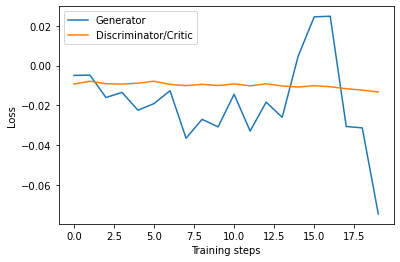

Change of gen loss to previous epoch:  tf.Tensor(-0.043339483, shape=(), dtype=float32)
Current Discriminator/Critic loss:  tf.Tensor(-0.013271814, shape=(), dtype=float32)
Change of Discriminator/Test loss to previous epoch:  tf.Tensor(-0.0009348672, shape=(), dtype=float32)


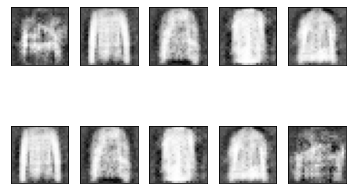

Time remain:  -1 day, 23:58:49.477533


In [ ]:
WGAN_generator= WGAN_Generator()
critic= Critic()

running_average_factor = 0.95

epochs = 20
gen_losses = []
critic_losses = []

start_time = time.time()
for epoch in range(epochs):
  try:
    epoch = epoch+1
    running_average_gen = 0
    running_average_critic = 0
    for input in train_dataset:
      gen_loss, critic_loss, generated_images = wasserstein_train_step(critic, WGAN_generator, input)
      running_average_gen = running_average_factor * running_average_gen  + (1 - running_average_factor) * gen_loss
      running_average_critic = running_average_factor * running_average_critic  + (1 - running_average_factor) * critic_loss
    gen_losses.append(running_average_gen)
    critic_losses.append(running_average_critic)
    clear_output(wait = True)
    print('Epoch: __ ' + str(epoch))
    visualize(gen_losses, critic_losses)
    visualize_images(generated_images)
    print("Time remain: ", calculateTime(epoch, time.time()-start_time, epochs))
  except KeyboardInterrupt as e:
    break

#### As we can see the resulting images of the WGAN are clearer and also their quality was varying less during the training process. Training for more epochs might have resulted in sharper images but the deadline ends in 52 min.